In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from R_interop import ZIFA
from R_interop import ZINB
from R_interop import SIMLR
from benchmarking import *
from helper import *
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
data_path = "/home/ubuntu/single-cell-scVI/data/Zeisel/"

# import and format

In [3]:
X = pd.read_csv(data_path + "expression_mRNA_17-Aug-2014.txt", sep="\t", low_memory=False).T
clusters = np.array(X[7], dtype=str)[2:]
precise_clusters = np.array(X[0], dtype=str)[2:]
celltypes, labels = np.unique(clusters, return_inverse=True)
_, precise_labels = np.unique(precise_clusters, return_inverse=True)
gene_names = np.array(X.iloc[0], dtype=str)[10:]
X = X.loc[:, 10:]
X = X.drop(X.index[0])
expression = np.array(X, dtype=np.int)[1:]

In [4]:
print expression.shape[0], " cells with ", expression.shape[1], " genes"

3005  cells with  19972  genes


In [5]:
for i in np.unique(labels):
    print i, clusters[np.where(labels == i)[0][0]], "\t" , len( np.where(labels == i)[0])

0 astrocytes_ependymal 	224
1 endothelial-mural 	235
2 interneurons 	290
3 microglia 	98
4 oligodendrocytes 	820
5 pyramidal CA1 	939
6 pyramidal SS 	399


In [6]:
def agg_clusters_2(c):
    new_c = np.zeros_like(c)
    for t in np.arange(c.shape[0]):
        if c[t] in [2, 6, 5]:
            new_c[t] = 1
        else:
            new_c[t] = 0
    return new_c

def agg_clusters_3(c):
    new_c = np.zeros_like(c)
    for t in np.arange(c.shape[0]):
        if c[t] in [2, 6, 5]:
            new_c[t] = 2
        elif c[t] in [1, 3]: 
            new_c[t] = 1
        else:
            new_c[t] = 0
    return new_c

def agg_clusters_4(c):
    new_c = np.zeros_like(c)
    for t in np.arange(c.shape[0]):
        if c[t] in [2, 6, 5]:
            new_c[t] = 3
        elif c[t] in [1, 3]: 
            new_c[t] = 2
        elif c[t] in [0]:
            new_c[t] = 1
        else:
            new_c[t] = 0
    return new_c

In [8]:
np.save("labels", labels)
np.save("labels_2", agg_clusters_2(labels))
np.save("labels_3", agg_clusters_3(labels))
np.save("labels_4", agg_clusters_4(labels))

In [7]:
# keep the most variable genes according to the biscuit paper
selected = np.std(expression, axis=0).argsort()[-558:][::-1]
expression = expression[:, selected]
gene_names = gene_names[selected].astype(str)

In [8]:
#train test split for log-likelihood scores
X_train, X_test, c_train, c_test, cp_train, cp_test = train_test_split(expression, labels, precise_labels,\
                                                                       random_state=0)

In [125]:
np.savetxt(data_path + "gene_expression", expression)
np.savetxt(data_path + "gene_name", gene_names, fmt="%s")
np.savetxt(data_path + "labels", labels)
np.savetxt(data_path + "precise_labels", precise_labels)

In [126]:
np.savetxt(data_path + "data_train", X_train)
np.savetxt(data_path + "data_test", X_test)
np.savetxt(data_path + "label_train", c_train)
np.savetxt(data_path + "label_test", c_test)
np.savetxt(data_path + "precise_label_train", c_train)
np.savetxt(data_path + "precise_label_test", c_test)

In [ ]:
X_zero, i, j, ix = dropout(X_train)
np.save(data_path + "imputation/X_zero.npy", X_zero)
np.save(data_path + "imputation/i.npy", i)
np.save(data_path + "imputation/j.npy", j)
np.save(data_path + "imputation/ix.npy", ix)

# Benchmarking

In [9]:
X_train = np.loadtxt(data_path + "data_train")
X_test = np.loadtxt(data_path + "data_test")
c_train = np.loadtxt(data_path + "label_train")
c_test = np.loadtxt(data_path + "label_test")
cp_train = np.loadtxt(data_path + "precise_label_train")
cp_test = np.loadtxt(data_path + "precise_label_test")

X_zero, i, j, ix = \
        np.load(data_path + "imputation/X_zero.npy"),\
        np.load(data_path + "imputation/i.npy"), \
        np.load(data_path + "imputation/j.npy"), \
        np.load(data_path + "imputation/ix.npy")

In [11]:
n_latent = 10

algorithms = [FactorAnalysis(n_components=n_latent), \
              ZIFA.ZIFA(n_components=n_latent)]
alg_names = ["FA", "ZIFA"]
alg_logs = [True, True]

In [23]:
for i, alg in enumerate(algorithms):
    print i, alg_names[i]
    
    data_train = X_train
    data_test = X_test
    
    if alg_logs:
        data_train = np.log(1 + X_train)
        data_test = np.log(1 + X_test)
        
    %time alg.fit(data_train)
    latent = alg.transform(data_train)
    
    print cluster_scores(latent, 2, agg_clusters_2(c_train))
    print cluster_scores(latent, 3, agg_clusters_3(c_train))
    print cluster_scores(latent, 4, agg_clusters_4(c_train))
    print cluster_scores(latent, 7, c_train)

    score = alg.score(data_test)
    if alg_logs:
        score -= np.mean(np.sum(data_test, axis=-1))
        
    print score

0 FA
CPU times: user 560 ms, sys: 200 ms, total: 760 ms
Wall time: 218 ms
[0.11581131621741758, 0.27242090518994611, 0.29792838642308994]
[0.1379795317324681, 0.35827752246474137, 0.31243455865964415]
[0.16330256646100366, 0.52810024826215751, 0.43436435453448607]
[0.21151757370266561, 0.78013724807955698, 0.78688963604064266]
-1304.09774005
1 ZIFA
CPU times: user 4min 59s, sys: 6min 5s, total: 11min 4s
Wall time: 2min 55s
[0.10760864940654481, 0.27739547166803474, 0.3047726295034825]
[0.13207018700785564, 0.33238196759272998, 0.23560128683050038]
[0.15602621812059733, 0.4890464265132512, 0.39260959628267939]
[0.20493195811465581, 0.7621022202234099, 0.76261580271279172]
-1366.15016113


In [31]:
zinb = ZINB.ZINB(n_components=n_latent, learn_V=True)
% time zinb.fit(X_train)
% time latent = zinb.transform(X_train)
print zinb.score(X_test)
print cluster_scores(latent, 2, agg_clusters_2(c_train))
print cluster_scores(latent, 3, agg_clusters_3(c_train))
print cluster_scores(latent, 4, agg_clusters_4(c_train))
print cluster_scores(latent, 7, c_train)

CPU times: user 1min 19s, sys: 12.3 s, total: 1min 32s
Wall time: 20min 40s
CPU times: user 9.77 s, sys: 9.15 s, total: 18.9 s
Wall time: 1min 34s
-1228.39587006
[0.26205785925921099, 0.85077172427089109, 0.91146263609638756]
[0.25990368754080045, 0.73732465648146661, 0.81737057824171977]
[0.28822051246643876, 0.7337572513361047, 0.720925920911064]
[0.26269815861277129, 0.77659655102041325, 0.72452418659778117]


In [10]:
simlr = SIMLR.SIMLR(n_clusters=7)
%time simlr.fit_transform(X_train)
clear_output()
print cluster_scores(simlr.F, 2, agg_clusters_2(c_train))
print cluster_scores(simlr.F, 3, agg_clusters_3(c_train))
print cluster_scores(simlr.F, 4, agg_clusters_4(c_train))
print cluster_scores(simlr.F, 7, c_train)

[0.33516367779334777, 0.39835696548154614, 0.33684455827985865]
[0.46728307982783412, 0.4139910315267521, 0.32127127330855243]
[0.56894896661008765, 0.68157449794601954, 0.59400128368031502]
[0.67235996392036357, 0.82658703928292632, 0.8043416418267535]


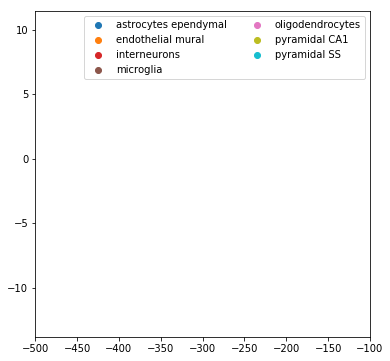

In [13]:
# Now have the legends
plt.figure(figsize=(6, 6))

cmap = plt.get_cmap("tab10", 7)
label =  ['astrocytes ependymal', 'endothelial mural', 'interneurons', 'microglia', 'oligodendrocytes', 'pyramidal CA1', 'pyramidal SS']
for t in np.unique(c_train):
    plt.scatter(simlr.ydata[c_train == t, 0], simlr.ydata[c_train == t, 1], c=cmap(t / 7.), label=label[int(t)])
plt.xlim((-500, -100))
plt.legend(ncol=2)
plt.savefig("Zeisel_legend.pdf", transparency=True)

## Latent Space tSNE

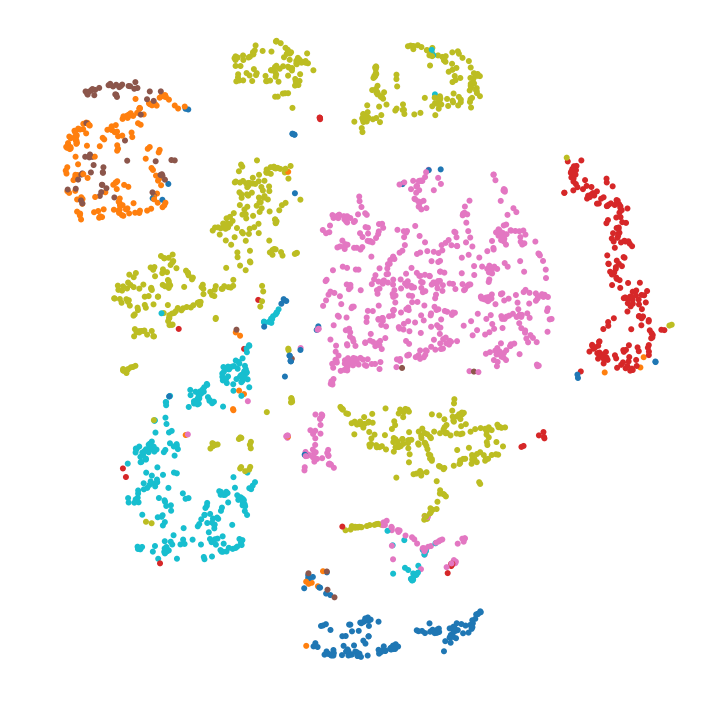

In [30]:
show_tSNE(PCA(n_components=10).fit_transform(np.log(1 + X_train)), c_train, cmap=plt.get_cmap("tab10", 7))

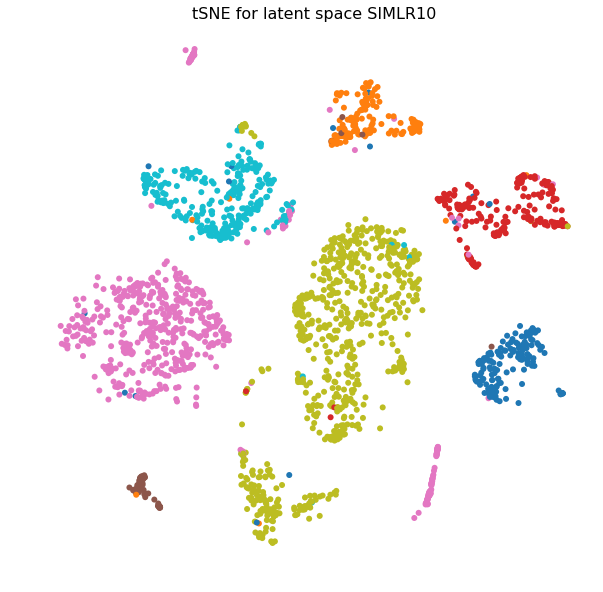

In [50]:
show_tSNE(simlr.ydata, c_train, cmap=plt.get_cmap("tab10", 7))

## imputation

#### save for BISCUIT

In [11]:
np.savetxt("expression_mRNA_zeiler_impute.txt", np.vstack((np.zeros(X_zero.shape[1]), X_zero)), delimiter="\t")

In [7]:
BISCUIT = pd.read_csv("/home/romain/BISCUIT_SingleCell_IMM_ICML_2016/output/plots/extras/Imputed_Y_countspace.txt", sep="\t")

In [8]:
print("BISCUIT", imputation_error(BISCUIT.as_matrix(), X_train, X_zero, i, j, ix))

('BISCUIT', 6.97117655)


In [19]:
# ZIFA Imputation
zifa = ZIFA(n_components=n_latent)
%time zifa.fit(np.log(1 + X_zero))
%time X_ZIFA_log = zifa.output_estimation(np.log(1 + X_zero))["EX"]
p_ZIFA = np.exp(- zifa.params["decay_coef"] * X_ZIFA_log**2)

CPU times: user 11min 34s, sys: 30min 37s, total: 42min 12s
Wall time: 9min 5s
CPU times: user 1min 4s, sys: 1min 54s, total: 2min 59s
Wall time: 23.6 s


In [20]:
print("ZIFA", imputation_error(np.exp(X_ZIFA_log) - 1, X_train, X_zero, i, j, ix))

('ZIFA', 3.1687476783939905)


In [ ]:
# ZINB Imputation
zinb = ZINB(n_components=n_latent)
for t in range(10):
    %time zinb.fit(X_zero)
    %time zinb.score(X_zero)
    fit_ZINB = zinb.output_estimation()
    X_ZINB = fit_ZINB[0]
    print("ZINB", imputation_error(X_ZINB, X_train, X_zero, i, j, ix))

CPU times: user 1min 18s, sys: 3.75 s, total: 1min 21s
Wall time: 6min 19s
CPU times: user 8.69 s, sys: 2.18 s, total: 10.9 s
Wall time: 57 s
('ZINB', 2.2998255601029913)
CPU times: user 55.4 s, sys: 3.72 s, total: 59.1 s
Wall time: 5min 24s
CPU times: user 7.76 s, sys: 2.2 s, total: 9.95 s
Wall time: 45.8 s
('ZINB', 2.3035853582486157)
CPU times: user 1min 3s, sys: 3.99 s, total: 1min 7s
Wall time: 6min 5s
CPU times: user 8.55 s, sys: 2.31 s, total: 10.9 s
Wall time: 41.4 s
('ZINB', 2.2989887352467209)
CPU times: user 1min 1s, sys: 4.06 s, total: 1min 5s
Wall time: 6min 13s


In [ ]:
# ZINB Imputation
zinb = ZINB(n_components=n_latent)
%time zinb.fit(X_zero)
%time zinb.score(X_zero)
fit_ZINB = zinb.output_estimation()
def softplus(x):
    return np.log(1 + np.exp(x))
X_ZINB = fit_ZINB[0]
logit_ZINB = fit_ZINB[1]
theta_ZINB = fit_ZINB[2]
log_pi_ZINB = -softplus(- logit_ZINB)

In [ ]:
print("ZINB", imputation_error(X_ZINB, X_train, X_zero, i, j, ix))

In [ ]:
log_p_ZINB = softplus(- logit_ZINB + theta_ZINB * np.log(theta_ZINB + 1e-8) \
                      - theta_ZINB * np.log(theta_ZINB + X_ZINB + 1e-8)) -  softplus( - logit_ZINB)
print("ZINB", imputation_error(X_ZINB, X_train, i, j, ix),\
      imputation_dropout(log_pi_ZINB, X_zero, i, j, ix), imputation_dropout(log_p_ZINB, X_zero, i, j, ix))
del fit_ZINB

In [16]:
mean_MAGIC = np.load(data_path + "imputation/X_zero_MAGIC.npy")
print("MAGIC", imputation_error(mean_MAGIC, X_train, X_zero, i, j, ix))

('MAGIC', 9.6733040235098731)


#### analyze the posterior

In [13]:
data_train = np.log(1 + X_train)
alg = FactorAnalysis(n_components=10)        
%time alg.fit(data_train)
latent = alg.transform(data_train) 

CPU times: user 528 ms, sys: 1.07 s, total: 1.6 s
Wall time: 243 ms


In [14]:
data_train = np.log(1 + X_train)
alg_zi = ZIFA(n_components=10)        
%time alg_zi.fit(data_train)
latent_zi = alg_zi.transform(data_train) 

CPU times: user 9min 14s, sys: 16min 33s, total: 25min 48s
Wall time: 3min 35s


In [37]:
def posterior_data(latent, mean_, components_, noise_variance_, hrange=(0, 10), posterior_sample=50, zifa=False, all_genes=True):
    #prepare the original values 
    
    if all_genes:
        all_index = i[ix], j[ix]
        y = X_train[all_index]
        y = y[X_zero[all_index] == 0]
    else:
        y = X_train[:, 253].flatten()
        

    (ymin, ymax) = hrange
    mask = y < ymax
    y = y[mask]
    l = y.shape[0]

    x = np.zeros((l, posterior_sample))

    # Now look at how the posterior covers the imputed values
    for t in range(posterior_sample):
        generate = mean_ + np.dot(latent, components_) \
                    + np.random.normal(0, scale = np.sqrt(noise_variance_))
        
        if zifa:
            decay = alg_zi.params["decay_coef"]
            generate *= np.random.binomial(1, 1-np.exp(- decay * generate **2))
            
        generate = np.exp(generate) - 1

        if all_genes:
            x_ = generate[all_index] 
            x_ = x_[X_zero[all_index] == 0]
        else:
            x_ = generate[:, 253].flatten()
            
            
        x[:, t] = x_[mask]

    if not all_genes:
        mask = np.mean(x, axis=1) < ymax
        x = x[mask]
        y = y[mask]

#     l = np.minimum(x.shape[0], y.shape[0])

#     x = x[:l]
#     y = y[:l]

    #index = np.random.choice(l, size=100000)
    #x_ = x[index]
    #y_ = y[index]
    
    x_ = x
    y_ = y
    
    return x_, y_

In [18]:
from scipy.stats import kde
def draw_custom_hist_data(x, y):
    
    # First digitize the original values
    # makes a K x K matrix
    K = 15
    hist, count_bins = np.histogram(mapping(y), bins=K)
    y_bin_assign = np.digitize(mapping(y), count_bins)
    
    # now we get for each value and for each eventual posterior the histogram assignment
    x_bin_assign = np.digitize(mapping(x), count_bins)
    
    #print np.unique(y_bin_assign)
    # Let us construct the full matrix to visualize
    
    mat = np.zeros(shape=(K, K))
    for k in range(1, K+1):
        assign_slice = x_bin_assign[y_bin_assign == k].flatten()
        assign_slice = assign_slice[assign_slice > 0]
        assign_slice = assign_slice[assign_slice < K+1]
        for i in range(1, K+1):
            assign_slice = np.append(assign_slice, i)
        #print np.unique(assign_slice)
        _, mat[k-1] = np.unique(assign_slice, return_counts=True)
        
    #print mat
    mat = mat / np.sum(mat, axis=0)
    plt.xticks(np.arange(mat.shape[0])[::2], inv_mapping(count_bins).astype(np.int)[::2])
    plt.yticks(np.arange(mat.shape[0])[::2], inv_mapping(count_bins).astype(np.int)[::2])
    plt.imshow(mat.T, origin='lower', interpolation="none")

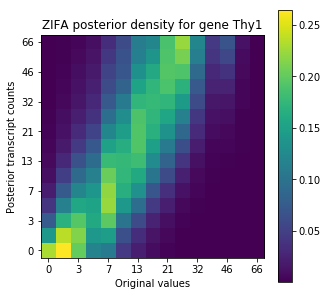

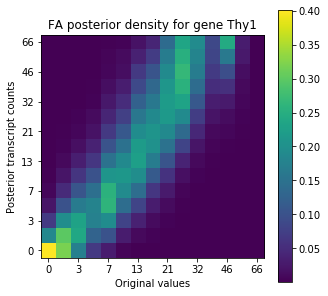

In [27]:
x_zi, y_zi = posterior_data(latent_zi, \
                    alg_zi.params["mus"][:, 0], alg_zi.params["A"].T, alg_zi.params["sigmas"][:, 0], \
                                 hrange=(0, 500), posterior_sample=500, zifa=True, all_genes=False)
x_fa, y_fa = posterior_data(latent, alg.mean_, alg.components_, alg.noise_variance_, \
                              hrange=(0, 500), posterior_sample=500, all_genes=False)

mapping = lambda x: np.log(1 + x / 10.)
inv_mapping = lambda x: (np.exp(x) - 1) * 10

plt.figure(figsize=(5, 5))
draw_custom_hist_data(x_zi, y_zi)
plt.title("ZIFA posterior density for gene Thy1")
plt.xlabel("Original values")
plt.ylabel("Posterior transcript counts")
plt.colorbar()
plt.savefig("ZIFA_posterior_Thy1.pdf", dpi=300)

plt.figure(figsize=(5, 5))
draw_custom_hist_data(x_fa, y_fa)
plt.title("FA posterior density for gene Thy1")
plt.xlabel("Original values")
plt.ylabel("Posterior transcript counts")
plt.colorbar()
plt.savefig("FA_posterior_Thy1.pdf", dpi=300)

In [38]:
x_zi, y_zi = posterior_data(latent_zi, \
                    alg_zi.params["mus"][:, 0], alg_zi.params["A"].T, alg_zi.params["sigmas"][:, 0], \
                                 hrange=(0, 500), posterior_sample=500, zifa=True)
x_fa, y_fa = posterior_data(latent, alg.mean_, alg.components_, alg.noise_variance_, \
                              hrange=(0, 500), posterior_sample=500)

In [29]:
def draw_box_data(x, y, nbins=10):
    def moving_average(a, n=3) :
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    hist, bins = np.histogram(np.log(1 + y), bins=nbins)
    bin_assign = np.digitize(np.log(1 + x), bins, right=False)
    data = [x[bin_assign == t].flatten() for t in np.unique(bin_assign) if (t > 0 and t <= nbins) ]
    return np.exp(moving_average(bins, n=2)) -1, data

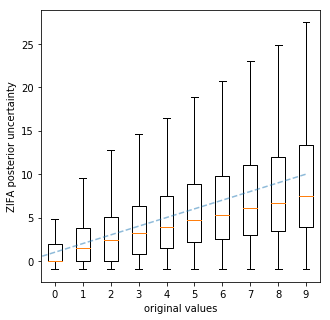

In [42]:
data = [x_zi[y_zi == t].flatten() for t in range(0, 10)]
plt.figure(figsize=(5, 5))
plt.boxplot(data, sym="")
plt.xticks(range(1, 11), range(0, 10))


l = np.linspace(0, 10, 50)
plt.plot(l, l, linestyle="--", alpha=0.5)
plt.xlabel("original values")
plt.ylabel("ZIFA posterior uncertainty")
plt.savefig("ZIFA_posterior.pdf", dpi=300)

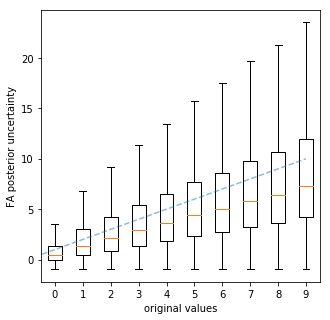

In [41]:
data = [x_fa[y_fa == t].flatten() for t in range(0, 10)]
plt.figure(figsize=(5, 5))
plt.boxplot(data, sym="")
plt.xticks(range(1, 11), range(0, 10))


l = np.linspace(0, 10, 50)
plt.plot(l, l, linestyle="--", alpha=0.5)
plt.xlabel("original values")
plt.ylabel("FA posterior uncertainty")
plt.savefig("FA_posterior.pdf", dpi=300)

# distance matrix

In [139]:
pca = PCA(n_components=10)
% time pca.fit(np.log(1 + X_train))
% time latent = pca.transform(np.log(1 + X_train))

CPU times: user 204 ms, sys: 288 ms, total: 492 ms
Wall time: 107 ms
CPU times: user 108 ms, sys: 192 ms, total: 300 ms
Wall time: 46.2 ms


In [17]:
celltypes = np.array(['astrocytes_ependymal', 'endothelial-mural', 'interneurons',
       'microglia', 'oligodendrocytes', 'pyramidal CA1', 'pyramidal SS'],
      dtype='|S64')
beloved_order = np.array(['interneurons', 'pyramidal SS', 'pyramidal CA1', 'endothelial-mural', \
 'microglia', 'astrocytes_ependymal', 'oligodendrocytes'])
from matplotlib import gridspec

mapping = [np.where(beloved_order == x)[0][0] for x in celltypes]

def visualize_distance(latent, labels, mapping):
    sorting_labels = [mapping[int(x)] for x in c_train]
    order_latent = np.vstack([x for _, x in sorted(zip(sorting_labels, latent), key=lambda pair: pair[0])])
    order_label = np.vstack([x for _, x in sorted(zip(sorting_labels, labels), key=lambda pair: pair[0])])
    #print order_label
    #lab = 
    distance = scipy.spatial.distance_matrix(order_latent, order_latent)  
    
    fig = plt.figure(figsize=(5, 5)) 
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 70], height_ratios=[1, 70])
    gs.update(wspace=0.05, hspace=0.05)
    ax0 = plt.subplot(gs[1])
    ax0.imshow(order_label.T, cmap='tab10', interpolation='none', aspect=100)
    ax0.axis('off')
    ax1 = plt.subplot(gs[3], sharex=ax0)
    dis= ax1.imshow(distance, cmap='hot', interpolation='none')
    fig.colorbar(dis, ax=ax1)
    ax1.axis('off')
    ax2 = plt.subplot(gs[2], sharey=ax1)
    ax2.imshow(order_label, cmap='tab10', interpolation='none', aspect=1/100.)
    ax2.axis('off')
    #plt.tight_layout()

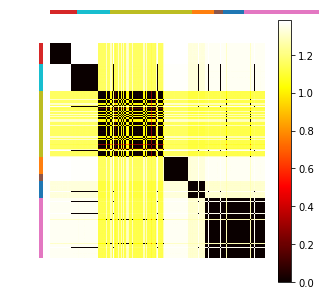

In [18]:
visualize_distance(simlr.F, c_train, mapping)
plt.savefig("SIMLR.pdf", dpi=300)

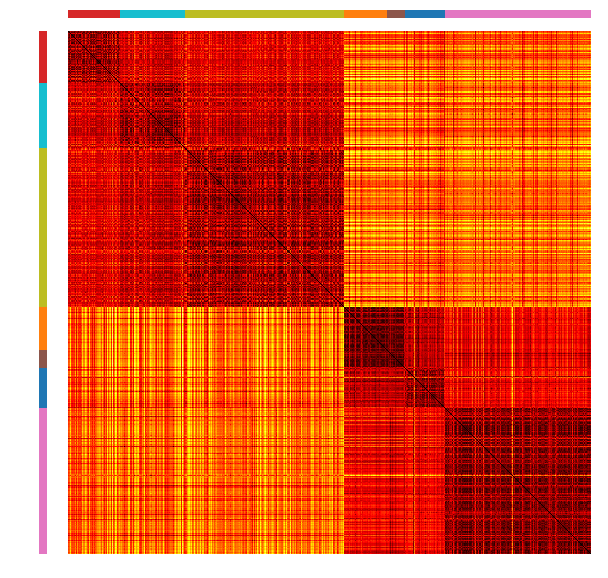

In [140]:
visualize_distance(latent, c_train, mapping)
plt.savefig("PCA_distance.pdf", dpi=300)

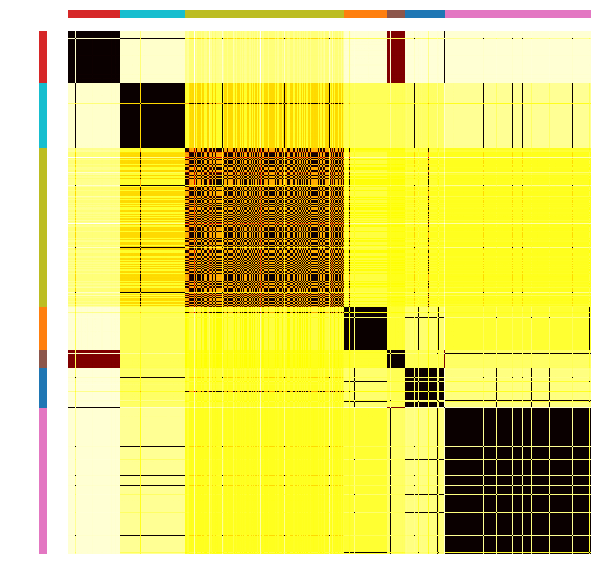

In [114]:
visualize_distance(simlr.F, c_train, mapping)
plt.savefig("SIMLR.pdf", dpi=300)

# Imputation

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

In [11]:
mean_MAGIC = np.load(data_path + "imputation/X_zero_MAGIC.npy")
print("MAGIC", imputation_error(mean_MAGIC, X_train, X_zero, i, j, ix))

('MAGIC', 9.6733040235098731)


In [13]:
def plot_imputation(imputed, original, zeros, i, j, ix, xtext):
    all_index = i[ix], j[ix]
    x, y = imputed[all_index], original[all_index]

    x = x[zeros[all_index] == 0]
    y = y[zeros[all_index] == 0]
    
    ymax = 10
    mask = x < ymax
    x = x[mask]
    y = y[mask]

    mask = y < ymax
    x = x[mask]
    y = y[mask]

    l = np.minimum(x.shape[0], y.shape[0])

    x = x[:l]
    y = y[:l]

    data = np.vstack([x, y])
    
    print data.shape
    
    plt.figure(figsize=(5, 5))

    axes = plt.gca()
    axes.set_xlim([0,ymax])
    axes.set_ylim([0,ymax])
    
    nbins=50

    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    k = kde.gaussian_kde(data)
    xi, yi = np.mgrid[0:ymax:nbins*1j, 0:ymax:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    plt.title(xtext, fontsize=12)
    plt.xlabel("Imputed counts")
    plt.ylabel('Original counts')
    
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap="Reds")
    
    a, _, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
    l = np.linspace(0, ymax)
    plt.plot(l, a * l, color='black')
    
    plt.plot(l, l, color='black', linestyle=":")


(2, 55932)


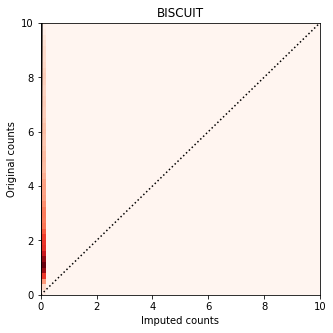

In [21]:
plot_imputation(BISCUIT.as_matrix(), X_train, X_zero, i, j, ix, "BISCUIT")
plt.savefig("BISCUIT_imputation.pdf", dpi=300)

(2, 50222)


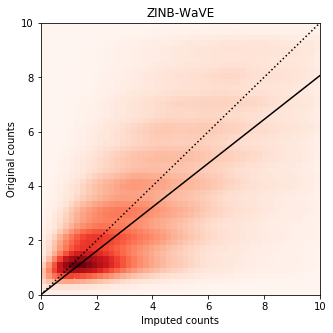

In [14]:
plot_imputation(X_ZINB, X_train, X_zero, i, j, ix, "ZINB-WaVE")
plt.savefig("ZINB_imputation.pdf", dpi=300)

(2, 55878)


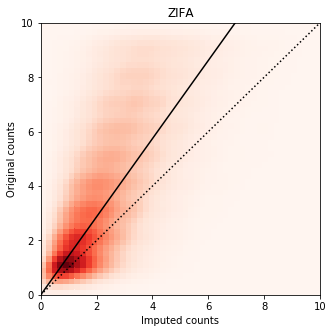

In [22]:
plot_imputation(np.exp(X_ZIFA_log) - 1, X_train, X_zero, i, j, ix, "ZIFA")
plt.savefig("ZIFA_imputation.pdf", dpi=300)

(2, 22235)


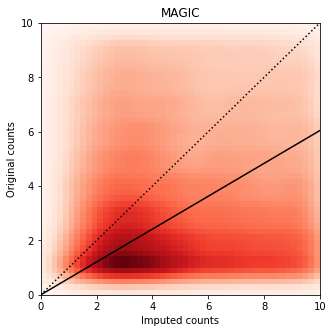

In [23]:
plot_imputation(mean_MAGIC, X_train, X_zero, i, j, ix, "MAGIC")
plt.savefig("magic_imputation.pdf", dpi=300)